# Fake news detection using machine learning





## 1. Import libraries

We start by importing the python libraries required for data handling, visualization, and machine learning.


In [1]:
# data handling and plotting libraries

import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt


In [2]:
# scikit learn tools for splitting, vectorizing, modeling, and tuning

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    roc_auc_score
)


## 2. Load dataset files

we load the two csv files
fake news articles in `fake.csv`
real news articles in `true.csv`


In [6]:
# load the datasets from csv into pandas dataframes
# quickly confirm the dataset sizes and preview rows

fake = pd.read_csv("fake.csv")
true = pd.read_csv("true.csv")

print("fake shape", fake.shape)
print("true shape", true.shape)

fake.head()

fake shape (23481, 4)
true shape (21417, 4)


,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


## 3. Label and merge the datasets

We assign labels so the models can learn the difference between classes.As,
label 0 means fake news
label 1 means real news

then we merge both datasets into one dataframe and jumble it to remove ordering bias


In [9]:
# assign labels and merge into a single dataframe
# shuffle the rows so training is not influenced by file ordering

fake["label"] = 0
true["label"] = 1

df = pd.concat([fake, true], ignore_index=True)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

df.head()


,title,text,subject,date,label
0,Ben Stein Calls Out 9th Circuit Court: Committ...,"21st Century Wire says Ben Stein, reputable pr...",US_News,"February 13, 2017",0
1,Trump drops Steve Bannon from National Securit...,WASHINGTON (Reuters) - U.S. President Donald T...,politicsNews,"April 5, 2017",1
2,Puerto Rico expects U.S. to lift Jones Act shi...,(Reuters) - Puerto Rico Governor Ricardo Rosse...,politicsNews,"September 27, 2017",1
3,OOPS: Trump Just Accidentally Confirmed He Le...,"On Monday, Donald Trump once again embarrassed...",News,"May 22, 2017",0
4,Donald Trump heads for Scotland to reopen a go...,"GLASGOW, Scotland (Reuters) - Most U.S. presid...",politicsNews,"June 24, 2016",1


In [11]:
# save the merged dataset

df.to_csv("dataset_combined_fake_real.csv", index=False)


## 4. Clean and prepare the text

machine learning models cannot directly use raw text
we build a single text column by combining title and article text
then we clean the text by removing urls, numbers, punctuation, and extra spaces


In [14]:
# define a simple cleaning function for text
# create content by combining title and text
# create a cleaned version of the content for modeling

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+", " ", text)
    text = re.sub(r"\d+", " ", text)
    text = text.translate(str.maketrans("", "", string.punctuation))
    text = re.sub(r"\s+", " ", text).strip()
    return text

df["content"] = (df["title"].fillna("") + " " + df["text"].fillna("")).astype(str)
df["content_clean"] = df["content"].apply(clean_text)


## 5. Exploratory data analysis

This section helps us understand the dataset before training models.


### 5.1 Class distribution

we check whether the dataset has a similar number of fake and real articles.
a balanced dataset helps models learn better.


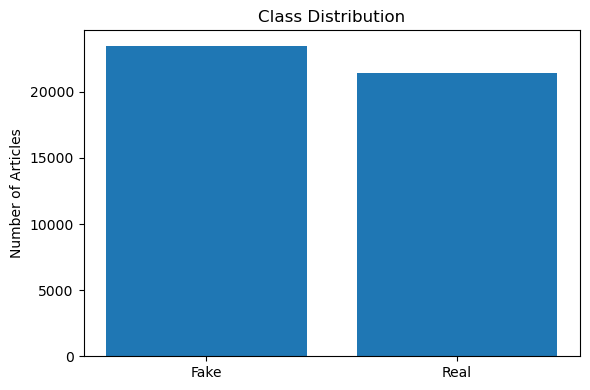

In [17]:
# count the number of samples per class and visualize it

class_counts = df["label"].value_counts().sort_index()

plt.figure(figsize=(6,4))
plt.bar(["Fake", "Real"], class_counts.values)
plt.title("Class Distribution")
plt.ylabel("Number of Articles")
plt.tight_layout()
plt.savefig("fig_01_class_distribution.png", dpi=200)
plt.show()


### 5.2 Text length distribution

we measure how long each article is in words
this can reveal whether one class tends to be shorter or longer.


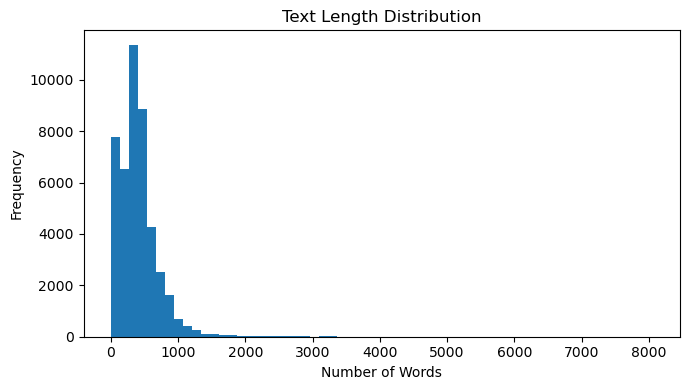

In [21]:
# compute word counts and plot a histogram

df["text_length"] = df["content_clean"].apply(lambda x: len(x.split()))

plt.figure(figsize=(7,4))
plt.hist(df["text_length"], bins=60)
plt.title("Text Length Distribution")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.tight_layout()
plt.savefig("fig_02_text_length_hist.png", dpi=200)
plt.show()


### 5.3 Word cloud visualization

Word clouds show the most frequent words in each class.
This can highlight differences in language patterns between fake and real news.


In [24]:
# import wordcloud library

from wordcloud import WordCloud, STOPWORDS


#### 5.3.1 Word cloud for fake news


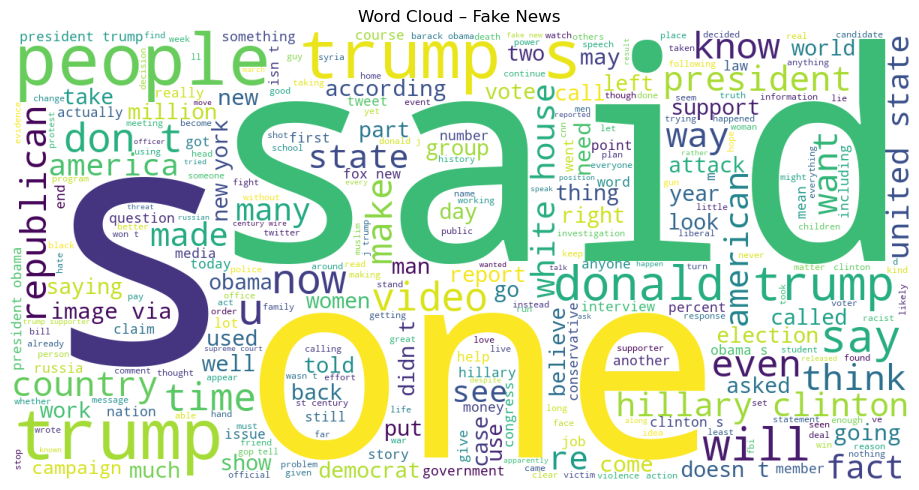

In [27]:
# build one large text string from fake articles
# generate and display the word cloud
# use to_image to avoid numpy compatibility issues

fake_text = " ".join(df[df["label"] == 0]["content_clean"])

wc_fake = WordCloud(
    width=1200,
    height=600,
    background_color="white",
    stopwords=STOPWORDS,
    max_words=300
).generate(fake_text)

plt.figure(figsize=(10,5))
plt.imshow(wc_fake.to_image())
plt.axis("off")
plt.title("Word Cloud – Fake News")
plt.tight_layout()
plt.savefig("fig_03_wordcloud_fake.png", dpi=200)
plt.show()


#### 5.3.2 Word cloud for real news


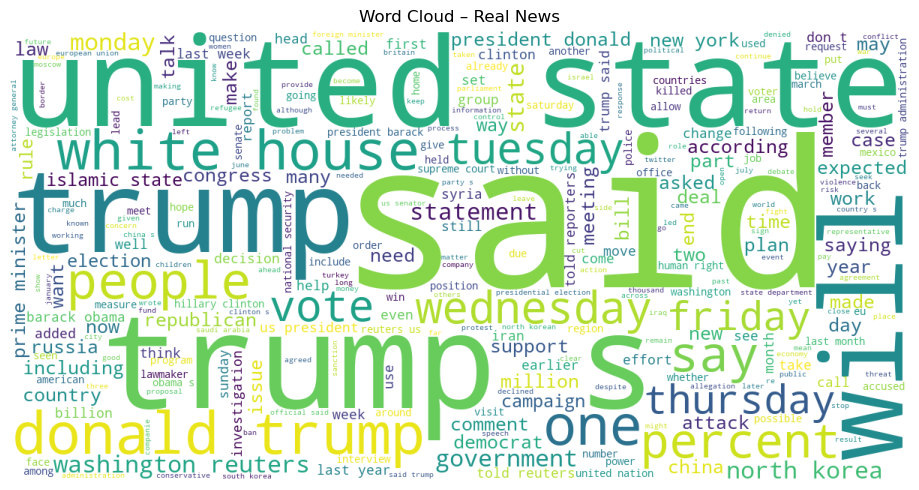

In [29]:
# build one large text string from real articles
# generate and display the word cloud
# use to_image to avoid numpy compatibility issues

real_text = " ".join(df[df["label"] == 1]["content_clean"])

wc_real = WordCloud(
    width=1200,
    height=600,
    background_color="white",
    stopwords=STOPWORDS,
    max_words=300
).generate(real_text)

plt.figure(figsize=(10,5))
plt.imshow(wc_real.to_image())
plt.axis("off")
plt.title("Word Cloud – Real News")
plt.tight_layout()
plt.savefig("fig_04_wordcloud_real.png", dpi=200)
plt.show()


## 6. Train test split

we split the dataset into training and testing sets
training set is used to learn patterns
test set is used only for final evaluation
we use stratify to keep the class ratio similar in both sets.


In [32]:
# split the data into train and test sets

X_train, X_test, y_train, y_test = train_test_split(
    df["content_clean"],
    df["label"],
    test_size=0.2,
    random_state=42,
    stratify=df["label"]
)


## 7. Feature extraction using tf idf

models require numeric features
tf idf converts text into vectors based on word importance.


In [36]:
# fit tf idf on training text and transform both train and test

vectorizer = TfidfVectorizer(
    stop_words="english",
    max_df=0.7,
    min_df=2,
    max_features=15000
)

Xtr = vectorizer.fit_transform(X_train)
Xte = vectorizer.transform(X_test)


## 8. Baseline model training

We train two baseline models:
a.multinomial naive bayes
b.logistic regression

Baseline results give a reference point before tuning.


In [38]:
# train naive bayes baseline model and evaluate it

nb_base = MultinomialNB()
nb_base.fit(Xtr, y_train)

nb_base_pred = nb_base.predict(Xte)
nb_base_acc = accuracy_score(y_test, nb_base_pred)

print("Naive Bayes Baseline Accuracy:", nb_base_acc)
print(classification_report(y_test, nb_base_pred, target_names=["Fake","Real"]))


Naive Bayes Baseline Accuracy: 0.9363028953229399
              precision    recall  f1-score   support

        Fake       0.93      0.94      0.94      4696
        Real       0.94      0.93      0.93      4284

    accuracy                           0.94      8980
   macro avg       0.94      0.94      0.94      8980
weighted avg       0.94      0.94      0.94      8980



In [39]:
# train logistic regression baseline model and evaluate it

lr_base = LogisticRegression(max_iter=300, solver="saga", n_jobs=-1)
lr_base.fit(Xtr, y_train)

lr_base_pred = lr_base.predict(Xte)
lr_base_acc = accuracy_score(y_test, lr_base_pred)

print("Logistic Regression Baseline Accuracy:", lr_base_acc)
print(classification_report(y_test, lr_base_pred, target_names=["Fake","Real"]))


Logistic Regression Baseline Accuracy: 0.9860801781737194
              precision    recall  f1-score   support

        Fake       0.99      0.99      0.99      4696
        Real       0.98      0.99      0.99      4284

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



## 9. Hyperparameter tuning

Hyperparameter tuning searches for better settings using cross validation.
We tune each model and then retrain it using the best parameters.


In [44]:
# tune naive bayes using grid search on alpha

nb_grid = GridSearchCV(
    MultinomialNB(),
    {"alpha": [0.01, 0.1, 0.5, 1.0]},
    cv=3,
    scoring="accuracy",
    n_jobs=-1
)

nb_grid.fit(Xtr, y_train)

nb_tuned = nb_grid.best_estimator_


In [45]:
# tune logistic regression using grid search on C

lr_grid = GridSearchCV(
    LogisticRegression(max_iter=300, solver="saga", n_jobs=-1),
    {"C": [0.1, 1, 10]},
    cv=3,
    scoring="accuracy",
    n_jobs=-1
)

lr_grid.fit(Xtr, y_train)

lr_tuned = lr_grid.best_estimator_


## 10. Final evaluation after tuning

We evaluate the tuned models on the test set and compare them with baseline performance.


In [48]:
# predict using tuned models and report accuracy and classification reports

nb_tuned_pred = nb_tuned.predict(Xte)
lr_tuned_pred = lr_tuned.predict(Xte)

nb_tuned_acc = accuracy_score(y_test, nb_tuned_pred)
lr_tuned_acc = accuracy_score(y_test, lr_tuned_pred)

print("Naive Bayes Tuned Accuracy:", nb_tuned_acc)
print("Logistic Regression Tuned Accuracy:", lr_tuned_acc)


Naive Bayes Tuned Accuracy: 0.9389755011135857
Logistic Regression Tuned Accuracy: 0.9930957683741648


## 11. Comparison table 

In [52]:
comparison_table = pd.DataFrame({
    "Model": ["Naive Bayes", "Logistic Regression"],
    "Baseline Accuracy": [nb_base_acc, lr_base_acc],
    "Tuned Accuracy": [nb_tuned_acc, lr_tuned_acc]
})

comparison_table

,Model,Baseline Accuracy,Tuned Accuracy
0,Naive Bayes,0.936303,0.938976
1,Logistic Regression,0.986080,0.993096
